In [1]:
import tensorflow as tf

%matplotlib inline
from pylab import *
import matplotlib
matplotlib.rcParams['figure.figsize']=[22, 20]
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from data_loaders import loc_det_train_loader, make_valid_localization_data

/home/florian/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
digits = load_digits()['data']
labels = load_digits()['target']

lblr = LabelBinarizer()

labels = lblr.fit_transform(labels)

tr_digits, tst_digits, tr_labels, tst_labels = train_test_split(digits, labels)
tst_digits, tst_coords = make_valid_localization_data(tst_digits, noise=0.1)

print(tst_digits.shape, tst_coords.shape, tst_labels.shape)

(450, 32, 32, 1) (450, 4) (450, 10)


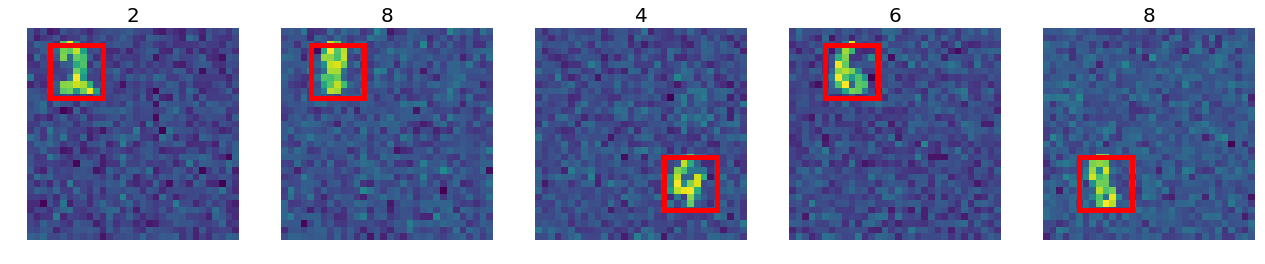

In [3]:
def plot_images(img_array, coord_array, labels, incl_true=False):
    fig, axes = plt.subplots(1, 5)
    for i, row in enumerate(axes):
        axes[i].axis('off')
        # get the coordinates in matplotlib rect format
        x = int(coord_array[i][0] * 32)
        y = int(coord_array[i][2] * 32)
        width = int(coord_array[i][1] * 32) - x
        height = int(coord_array[i][3] * 32) - y
        # add rectangle to the image
        axes[i].add_patch(patches.Rectangle((x, y), 
                                             width, height, fill=False, linewidth=5, color='r'))
        axes[i].set_title(str(np.argmax(labels[i])), fontsize=20)
        
        # true values are a global variable in this notebook so we'll just pull it from there
        if incl_true:
            # get the coordinates of the true value
            t_x = int(tst_coords[i][0] * 32)
            t_y = int(tst_coords[i][2] * 32)
            t_width = int(tst_coords[i][1] * 32) - x
            t_height = int(tst_coords[i][3] * 32) - y
            # add the true bounding box
            axes[i].add_patch(patches.Rectangle((t_x, t_y), 
                                                 t_width, t_height, fill=False, linewidth=5, linestyle=':', color='y'))
        axes[i].imshow(tst_digits[i].squeeze())
    plt.show()

plot_images(tst_digits, tst_coords, tst_labels)

In [4]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 32, 32, 1), name='X')
    
with tf.name_scope('targets_coord_placeholder'):
    y_coords = tf.placeholder(tf.float32, shape=(None, 4), name='y')
    
with tf.name_scope('targets_class_placeholder'):
    y_class = tf.placeholder(tf.float32, shape=(None, 10), name='y')

In [5]:
import neural_net_layers as nn

with tf.name_scope('cnn'):
    conv_1 = nn.conv_layer(X, in_dims=1, n_kernels=8, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = nn.max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = nn.conv_layer(pool_1, in_dims=8, n_kernels=16, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = nn.max_pool(conv_2, pool_size=2, name='pool_b')
    
    # it's important to watch your tensor shapes when using CNNs because you have to flatten
    # the representation for a dense layer, or you may downsample to a 0x0 feature map
    flat = tf.reshape(pool_2, [-1, 8*8*16])
    
    # regression head for the localization
    dense_a = nn.dense_layer(flat, 32, name='dense_layer_coord', activation=tf.nn.relu)
    y_pred_coords = nn.dense_layer(dense_a, 4, name='coord_output') 
    
    # classification head for the class labels
    dense_b = nn.dense_layer(flat, 32, name='dense_layer_class', activation=tf.nn.relu)
    y_pred_class = nn.dense_layer(dense_b, 10, name='class_output') 

In [6]:
with tf.name_scope('loss'):
    # coordinate loss
    error = y_pred_coords - y_coords
    loss = tf.reduce_mean(tf.square(error), name='mse')
    # class loss
    loss += (0.1 * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_class, logits=y_pred_class)))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.0005, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('class_prediction'):
    class_predictions = y_pred_class
    
with tf.name_scope('coord_prediction'):
    coord_predictions = y_pred_coords

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
EPOCHS = 150

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        loc_loader = loc_det_train_loader(tr_digits, tr_labels, noise=0.1)
        for X_b, y_b_coord, y_b_class in loc_loader:
            _, train_loss = sess.run([train_step, loss], feed_dict={X: X_b, y_coords: y_b_coord, y_class: y_b_class})
            
        if e % 3 == 0:
            print('loss:', train_loss)
            
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/cnn_mnist_loc.ckpt')

loss: 0.2353906
loss: 0.23369457
loss: 0.23300777
loss: 0.23710732
loss: 0.22376837
loss: 0.22722633
loss: 0.22457652
loss: 0.228104
loss: 0.23515138
loss: 0.20005272
loss: 0.16834082
loss: 0.22765075
loss: 0.22393204
loss: 0.20667484
loss: 0.17547195
loss: 0.18109581
loss: 0.16496867
loss: 0.18714303
loss: 0.1347869
loss: 0.07828797
loss: 0.0634462
loss: 0.044062804
loss: 0.12077062
loss: 0.12132087
loss: 0.08492343
loss: 0.07431008
loss: 0.042481396
loss: 0.082031846
loss: 0.054354914
loss: 0.012260017
loss: 0.025554422
loss: 0.020593874
loss: 0.04980135
loss: 0.007253599
loss: 0.035637975
loss: 0.08142351
loss: 0.026438529
loss: 0.04581583
loss: 0.036454268
loss: 0.02880588
loss: 0.007962032
loss: 0.0032690503
loss: 0.022514563
loss: 0.013932957
loss: 0.043358006
loss: 0.048407618
loss: 0.002126025
loss: 0.017401945
loss: 0.049034916
loss: 0.039706916


In [8]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model/cnn_mnist_loc.ckpt')
    coords_preds, class_preds = sess.run([y_pred_coords, y_pred_class], feed_dict={X: tst_digits[:10]})

INFO:tensorflow:Restoring parameters from ./saved_model/cnn_mnist_loc.ckpt


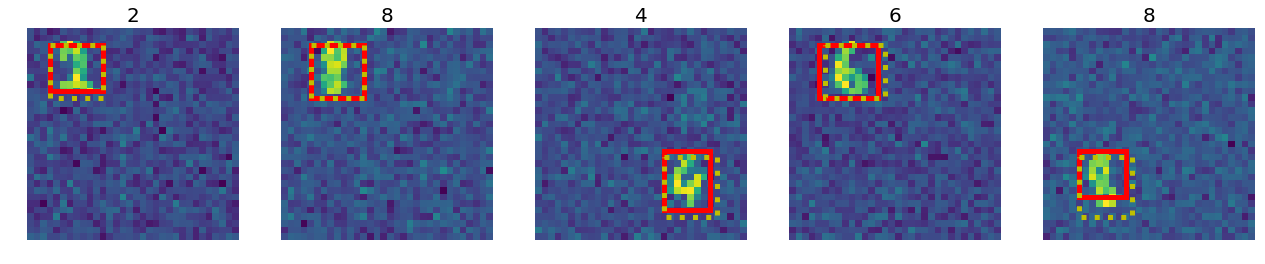

In [9]:
plot_images(tst_digits, coords_preds, class_preds, incl_true=True)